Fit for the zero-point of the ITFR, using the slope as calibrated from the Coma cluster in the `Coma-Fuji-ITFR_KAD.ipynb` notebook.

In [1]:
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

from scipy.optimize import minimize

import corner

#from hyperfit.linfit import LinFit

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#from VI_functions import get_cutout

import pickle

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from line_fits import param_invert

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5 # Set 0-pt for the TFR

# Data

## fuji

In [3]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
#tfuji = Table.read('/Users/kellydouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


## SGA

Read in our version of the SGA that includes distances from the Extragalactic Distance Database.  (This file was made with the `data_match.ipynb` notebook.)

In [4]:
SGA = Table.read('../SGA_distances.fits')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.033616345,0.029198052,0.031941395,0.031132452,0.028080799,0.030865192,0.029955743,0.02722575,0.030135926,0.029090546,0.026788738,0.02959205,0.028436601,17.799881,1.3952494,0.83855844,

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

### Filter SGA to keep only those objects with center observations and independent distances

In [10]:
distances = (SGA['DM_Stellar'] != -1) | (SGA['DM1_SN'] != -1)
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have independent distances
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][distances & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with distances and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with distances:', len(axis_dist))

fuji galaxies with distances and good center observations: 11
fuji off-center observations in galaxies with distances: 25


# Calculate the rotational velocities

In [11]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

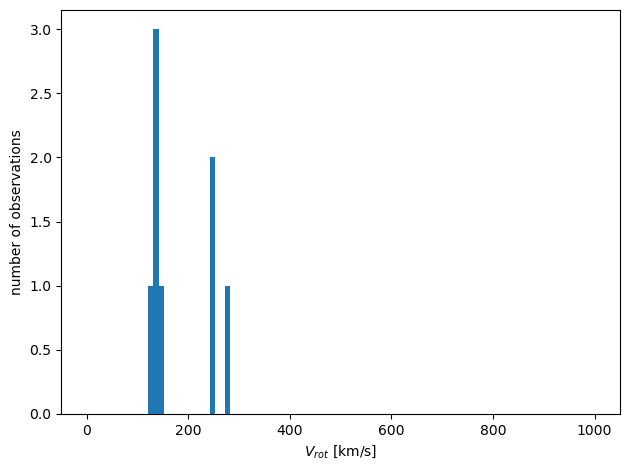

In [12]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies with distances suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [13]:
r0p3 = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3 & Vgood]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

7 3


## Relative velocity cut

In [14]:
good_deltaV = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_dist[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_dist[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [15]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

7 3


## Inclination angle cut

In [16]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [17]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_deltaV_axis_dist[edge]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

6 2


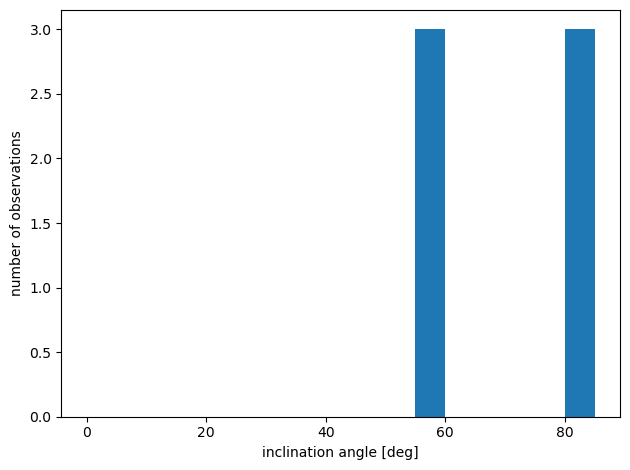

In [18]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_dist['cosi2']))*180/np.pi, bins=np.arange(0, 90, 5))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

## Morphology cut

In [19]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [20]:
spirals = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

6 2


In [21]:
SGA_idx = []

for SGA_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    SGA_idx.append(SGA_dict[SGA_id])

SGA[SGA_idx]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog,Z_DESI,ZERR_DESI,cosi2
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25,float64,float64,float32
294387,SGA-2020 294387,PGC039073,39073,183.547164,-0.831551,SABc,171.72,0.7780365,0.561048,0.024841517,23.520481,15.437,False,LEDA-20181114,106169,PGC039073,1,True,183.547164,-0.831551,0.7780365,1836m007,183.5471939888577,-0.8316111360355423,1.2215545,SB26,170.44017,0.5814847,183.54718532704396,-0.8315369651746233,30.07738,12.846199,12.395062,11.759229,8.509257,11.53522,14.766707,18.282831,22.028744,25.829937,29.480642,33.008987,36.646637,16.52693,15.968272,15.577775,16.17626,15.640676,15.267396,15.939795,15.423002,15.057729,15.767317,15.26203,14.904332,15.642654,15.141757,14.787272,15.55682,15.060615,14.709526,15.498996,15.00487,14.656994,15.462121,14.968573,14.623675,15.437742,14.945529,14.603001,0.038360342,0.061051294,0.059315868,0.09041882,0.07770962,0.099839635,0.10327726,0.10800127,0.15686321,0.008838212,0.009582073,0.0097316895,0.007513806,0.008082654,0.008192047,0.0066172783,0.007089283,0.007204685,0.005913486,0.006328169,0.006462018,0.005406668,0.005792954,0.0059218905,0.005074407,0.005446651,0.0055868314,0.0048628864,0.0052201203,0.005371191,0.004731652,0.005074616,0.0052398327,0.00464134

## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [27]:
for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    print(sga_id)
    
    tf_list = good_edge_spirals_axis_dist[good_edge_spirals_axis_dist['SGA_ID'] == sga_id]
    center_list = centers_dist[centers_dist['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    '''
    # break

294387
cache/coma_39627769688098202.jpg exists.
464075
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=242.48098745213719&dec=43.12912634553939&zoom=14&layer=ls-dr9&size=441&sga


No targets need to be removed - both objects and their observations pass VI.

# Zero-point calibration

## Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \bar{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [22]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [23]:
# Make a catalog of just those galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

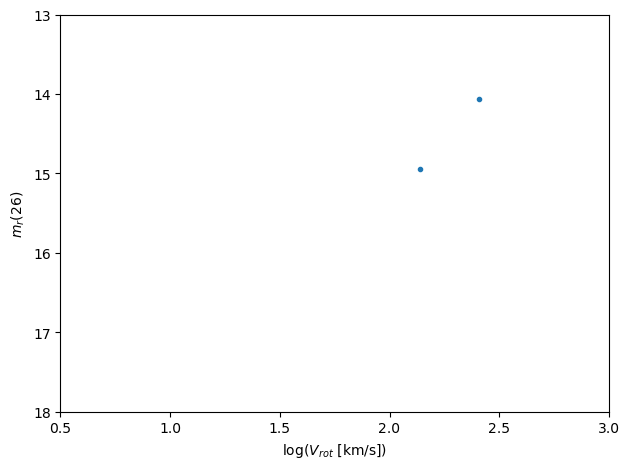

In [24]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR'], 
             fmt='.')

plt.xlim([0.5, 3])
plt.ylim([18, 13])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Compute the absolute magnitudes based on the distance measurements

\begin{equation}
  M_r - 5\log h = m_r - \mu - 5\log h
\end{equation}
where $h$ is the reduced Hubble constant used to calibrate the distance modulus, $\mu$.

Both of our galaxies have distance moduli from Stahl et al. (2021), which *appears* to use $h = 1$.  Therefore, the distance moduli we have to use are $\mu_h = \mu - 5\log h$.

In [25]:
SGA_0pt

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog,Z_DESI,ZERR_DESI,cosi2,V_0p33R26,V_0p33R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25,float64,float64,float32,float64,float64
294387,SGA-2020 294387,PGC039073,39073,183.547164,-0.831551,SABc,171.72,0.7780365,0.561048,0.024841517,23.520481,15.437,False,LEDA-20181114,106169,PGC039073,1,True,183.547164,-0.831551,0.7780365,1836m007,183.5471939888577,-0.8316111360355423,1.2215545,SB26,170.44017,0.5814847,183.54718532704396,-0.8315369651746233,30.07738,12.846199,12.395062,11.759229,8.509257,11.53522,14.766707,18.282831,22.028744,25.829937,29.480642,33.008987,36.646637,16.52693,15.968272,15.577775,16.17626,15.640676,15.267396,15.939795,15.423002,15.057729,15.767317,15.26203,14.904332,15.642654,15.141757,14.787272,15.55682,15.060615,14.709526,15.498996,15.00487,14.656994,15.462121,14.968573,14.623675,15.437742,14.945529,14.603001,0.038360342,0.061051294,0.059315868,0.09041882,0.07770962,0.099839635,0.10327726,0.10800127,0.15686321,0.008838212,0.009582073,0.0097316895,0.007513806,0.008082654,0.008192047,0.0066172783,0.007089283,0.007204685,0.005913486,0.006328169,0.006462018,0.005406668,0.005792954,0.0059218905,0.005074407,0.005446651,0.0055868314,0.0048628864,0.0052201203,0.005371191,0.00473

In [26]:
SGA_0pt['R_ABSMAG_SB26'] = SGA_0pt['R_MAG_SB26'] - SGA_0pt['DM1_SN']
SGA_0pt['R_ABSMAG_SB26_err'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR']**2 + SGA_0pt['e_DM1_SN']**2)

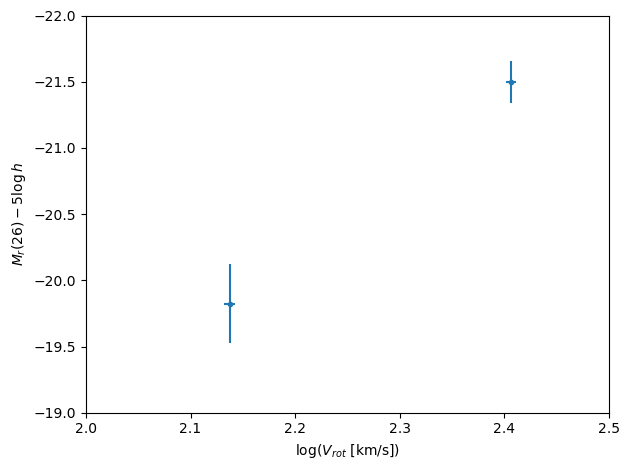

In [27]:
plt.figure(tight_layout=True)

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_err'], 
             fmt='.')

plt.xlim([2, 2.5])
plt.ylim([-19, -22])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$M_r (26) - 5\log h$');

## Fit the ITFR by minimizing $\chi^2$

This is taken from Sec. 15.3 of *Numerical Recipes*

In [28]:
def zero_point(b, m, x):
    '''
    Equation of a line
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of line (this is what is being fit for)
    
    m : float
        Slope of line
    
    x : np.ndarray of shape (n,)
        x-values of line
    
    
    RETURNS
    =======
    
    y : np.ndarray of shape (n,)
        y-values calculated with the provided inputs
    '''
    
    y = m*x + b
    
    return y

In [29]:
def calculate_chi2(b, m, x, x_err, y, y_err):
    '''
    Calculate the chi2 value of the current line.
    
    
    PARAMETERS
    ==========
    
    b : float
        y-intercept of the line (this is what is being fit for)
        
    m : floats
        Slope of the line
    
    x, x_err : np.ndarrays of shape (n,)
        x-values and uncertainties in the x-values
    
    y, y_err : np.ndarrays of shape (n,)
        y-values and uncertainties in the y-values
    
    
    RETURNS
    =======
    
    chi2 : float
        Chi2 value of the current best fit (given by b)
    '''
    
    ############################################################################
    # Calculate the values of the current best-fit line
    #---------------------------------------------------------------------------
    y_fit = zero_point(b, m, x)
    ############################################################################
    
    
    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((y - y_fit)**2/(y_err**2 + (m*x_err)**2))
    
    #chi2_norm = chi2/(len(x) - 1) # Only one free parameter in this fit
    ############################################################################
    
    return chi2#_norm

Slope for ITFR: $w_0 = -0.134 \pm 0.023$ or $m = -7.47^{+1.11}_{-1.44} = -7.47\pm 1.46$ (from `Coma-Fuji-ITFR_KAD.ipynb`)

*(Updated 8/17/23)*

In [30]:
# From hyperfit
w0_fit = -0.134
w0_fit_err = 0.023

m_fit = -7.47
m_fit_err = 1.46

In [31]:
w1_guess = -0.2

# Segev recommends that we generate a bunch of slopes based on its uncertainty, and run the fit a bunch of times.

N_samples = 10000

rng = np.random.default_rng()
w0_random = rng.normal(w0_fit, w0_fit_err, size=N_samples)

w1_fit_array = np.nan*np.ones(N_samples)

# Fit for w1 using the actual slope
result = minimize(calculate_chi2, 
                  w1_guess, 
                  args=(w0_fit, 
                        SGA_0pt['R_ABSMAG_SB26'], SGA_0pt['R_ABSMAG_SB26_err'], 
                        np.log10(SGA_0pt['V_0p33R26']) - V0, 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']), 
                  bounds=[[-10, 5]])
w1_fit = result.x[0]

for i in range(N_samples):
    result = minimize(calculate_chi2, 
                      w1_guess, 
                      args=(w0_random[i],  
                            SGA_0pt['R_ABSMAG_SB26'], SGA_0pt['R_ABSMAG_SB26_err'], 
                            np.log10(SGA_0pt['V_0p33R26']) - V0, 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']), 
                      bounds=[[-10, 5]])
    
    if result.success:
        w1_fit_array[i] = result.x[0]

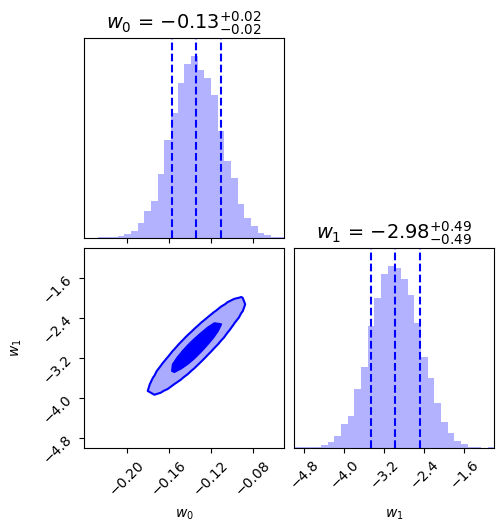

In [35]:
samples = np.stack((w0_random, w1_fit_array))
samples = samples[:, np.isfinite(w1_fit_array)]

fig = corner.corner(samples.T, bins=30, smooth=1,
                    range=[[-0.24, -0.05], [-5, -1]],   # Range for w0, w1. Adjust as needed.
                    labels=['$w_0$', '$w_1$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'0-pt calibration'},
                    title_kwargs={"fontsize": 14})

plt.savefig('../../Figures/SV/fuji_0pt_corner_20230817.png', dpi=150)

In [33]:
w1_fit_err = np.nanstd(w1_fit_array)

_, b_fit, cov_mb = param_invert(w0_fit, w1_fit, np.cov(samples))

# Save this covariance matrix
temp_outfile = open('cov_ab_fuji_zero-point_ITFR_KAD.pickle', 'wb')
pickle.dump((cov_mb), temp_outfile)
temp_outfile.close()

print('w1 : {:6.2f} +/- {:.2f}'.format(w1_fit, w1_fit_err))
print(' b : {:6.2f} +/- {:.2f}'.format(b_fit, np.sqrt(cov_mb[1,1])))

w1 :  -2.98 +/- 0.49
 b : -22.27 +/- 0.23


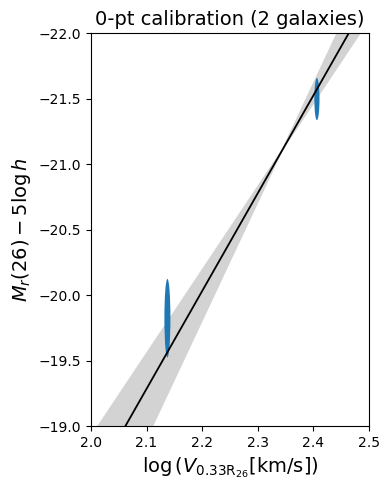

In [34]:
#sigmas = hf.get_sigmas()
xvals = np.linspace(1., 3., 1000)
yvals = m_fit * (xvals - V0) + b_fit

# Calculate all of the best fits
yvals_random = []
for i in range(N_samples):
    m_random_i, b_fit_i, _ = param_invert(w0_random[i], w1_fit_array[i], np.cov(samples))
    yvals_random.append((xvals - V0)*m_random_i + b_fit_i)
yvals_random = np.asarray(yvals_random)
edges = np.nanpercentile(yvals_random, [16, 84], axis=0)

# Pack info into data
data = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x_err = 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']
y_err = SGA_0pt['R_ABSMAG_SB26_err']
corr_xy = np.zeros_like(x_err)

# Generate ellipses
ells = [
    Ellipse(
        xy=[data[0][i], data[1][i]],
        width=2*y_err[i],
        height=2*x_err[i],
        angle=np.rad2deg(np.arccos(corr_xy[i])),
    )
    for i in range(len(data[0]))
]

# Make the plot
fig, ax = plt.subplots(figsize=(4,5), tight_layout=True)
ax.fill_between(xvals, edges[0], edges[1], color="lightgray")
for i, e in enumerate(ells):
    ax.add_artist(e)
    e.set_edgecolor('None')
ax.plot(xvals, yvals, c="k", marker="None", ls="-", lw=1.3)#, alpha=0.9)
ax.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax.set_ylabel(r"$M_r(26) - 5\log h$", fontsize=14)
ax.set_title("0-pt calibration ({} galaxies)".format(len(SGA_0pt)), fontsize = 14)
ax.set_xlim(2, 2.5)
ax.set_ylim(-19, -22);

plt.savefig('../../Figures/SV/fuji_0pt_TFR_20230817.png', dpi=150)